### Simulating a mortgage portfolio (II)

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month. To start, we model all mortgages with the lineair interest rate model.

See also: https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data.  In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers can choose the fixed interest period they select. Their choice will be influenced by market expectations, and the rates offered by the bank. 

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import timedelta
from dateutil.parser import parse

from src.models.bank_model import Bankmodel
from src.data.zerocurve import Zerocurve
from src.data.interest import Interest
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Create data objects
zerocurve = Zerocurve()
interest = Interest()

In [18]:
# Get zero curve historic rates
zerocurve.read_data()
# Get mortgage historic rates
interest.read_data()

2023-03-19 13:33:24.513 | INFO     | src.data.dataset:read_data:26 - reading zerocurve data from ESW.
c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
2023-03-19 13:33:25.667 | INFO     | src.data.dataset:read_data:26 - reading interest data from ESW.


<Response [200]>

In [19]:
zerocurve.save_data()
interest.save_data()

2023-03-19 13:33:26.075 | INFO     | src.data.dataset:save_data:55 - saving zerocurve data to file.
2023-03-19 13:33:26.442 | INFO     | src.data.dataset:save_data:55 - saving interest data to file.


In [20]:
# Load data from csv file - not directly from ECB
zerocurve.load_data()
interest.load_data()

2023-03-19 13:33:26.664 | INFO     | src.data.dataset:load_data:45 - loading zerocurve data from file.
c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
2023-03-19 13:33:26.881 | INFO     | src.data.dataset:load_data:45 - loading interest data from file.


In [21]:
pos_date = zerocurve.df.index[-1]
bankmodel = Bankmodel(pos_date )
bankmodel.generate_mortgage_contracts(n = 100, df_i = interest.df,amount = 100000)
bankmodel.df_mortgages.head()

2023-03-19 13:33:27.160 | INFO     | src.models.bank_model:generate_mortgage_contracts:121 - Added 100 mortgages to our portfolio.
2023-03-19 13:33:29.229 | INFO     | src.models.bank_model:generate_mortgage_contracts:125 - Added 18712 cashflows to our model.


,category,fixed_period,years,start_date,principal,period,interest,contract
0,3,>10 years,20,2016-10-20,100000,2016-10-01,2.98,0
1,3,>10 years,20,2006-04-03,100000,2006-04-01,3.15,1
2,3,>10 years,20,2016-03-10,100000,2016-03-01,3.15,2
3,1,1>5 years,5,2021-07-19,100000,2021-07-01,1.58,3
4,3,>10 years,20,2015-04-22,100000,2015-04-01,3.45,4


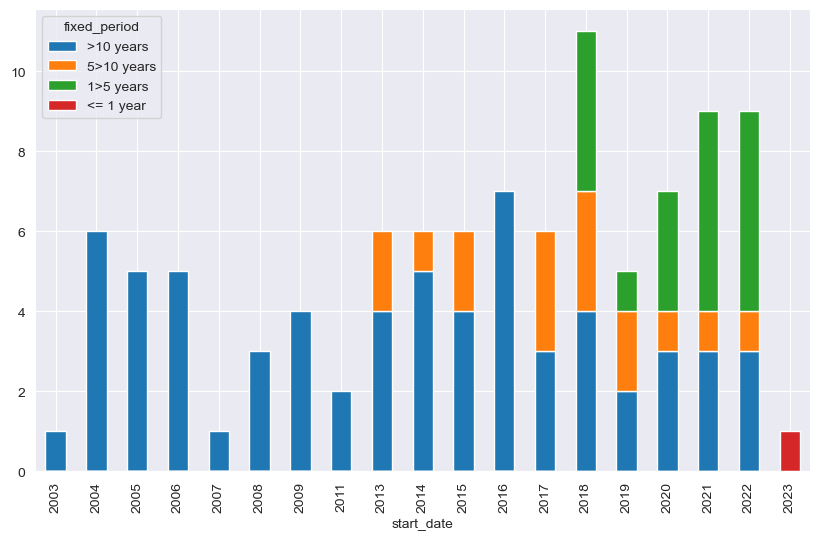

In [22]:
bankmodel.plot_contracts();

### Non Maturity Deposits
- Core vs Non Core balances

For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)

In [23]:
bankmodel.generate_nonmaturing_deposits(principal = 9000000, core = 0.4, maturity = 54)

,period,cashflow,value_dt,type
0,1,-5400000,2023-03-01,deposits
1,2,-3600000,2027-08-28,deposits


In [24]:
pos_date = zerocurve.df.index[-1]
rate = zerocurve.df.loc[pos_date].query('tenor == 120')['rate'][0]
df_cashflows = bankmodel.generate_funding(principal = 1000000, rate = rate, maturity = 120)
df_cashflows

,period,cashflow,value_dt,type
0,1,-27670.0,2023-02-28,Funding
1,2,-27670.0,2024-02-28,Funding
2,3,-27670.0,2025-02-28,Funding
3,4,-27670.0,2026-03-02,Funding
4,5,-27670.0,2027-03-01,Funding
5,6,-27670.0,2028-02-28,Funding
6,7,-27670.0,2029-02-28,Funding
7,8,-27670.0,2030-02-28,Funding
8,9,-27670.0,2031-02-28,Funding
9,10,-1027670.0,2032-03-01,Funding


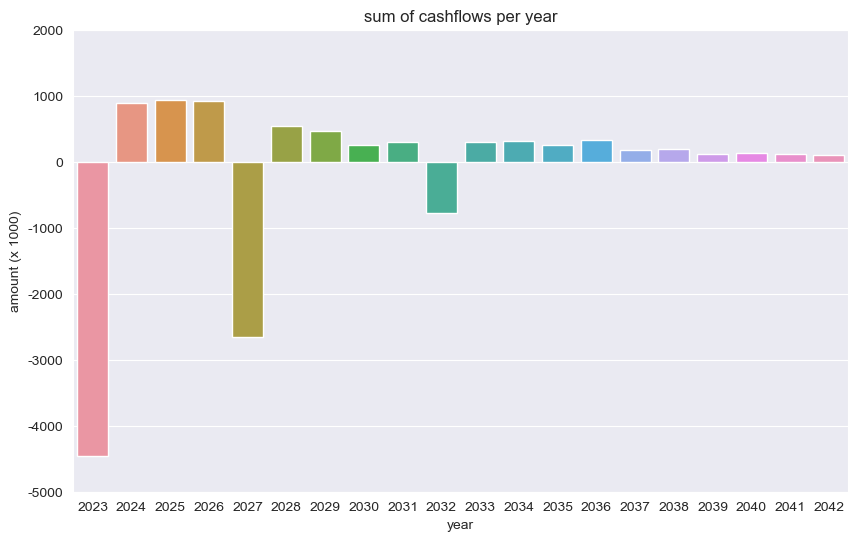

In [25]:
bankmodel.plot_cashflows()

### npv calculation

$$NPV = {{Cashflow} \over (1+i)^T}.$$
$$DF_0^T = [1+R_{zc}]^{-T})$$
where:
- $DF_0^T$  = a discount factor with maturity T
- $R_{zc}$ = A zero coupon interest rate
- $T$ = Maturity of the zero rate, in years (calculated as days/365)

In [27]:
result = bankmodel.calculate_npv(zerocurve)
print (f"npv = {result:,.0f}")
r1 = bankmodel.calculate_risk(zerocurve,200,'Parallel')
print (f"r1 = {r1:,.0f}")

npv = -2,143,822
r1 = -302,717


In [28]:
bankmodel.step()
zerocurve.step()
result = bankmodel.calculate_npv(zerocurve)
print (f"NPV = {result:,.0f}")
r1 = bankmodel.calculate_risk(zerocurve,200,'Parallel')
print (f"r1 = {r1:,.0f}")

2023-03-19 13:33:55.614 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-01 00:00:00.


NPV = -2,139,550
r1 = -302,896


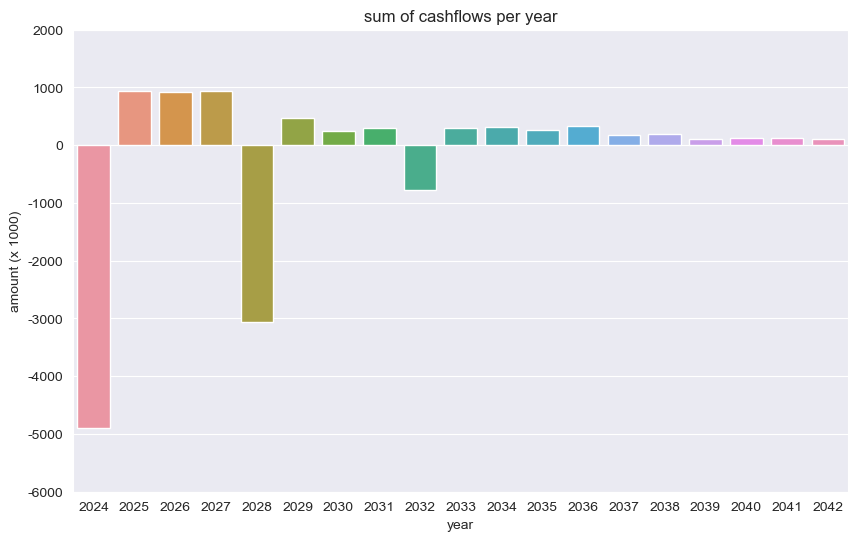

In [34]:
bankmodel.plot_cashflows()

In [97]:
zerocurve.df.loc[pos_date]

,tenor,rate,value_dt
rate_dt,,,
2023-02-28,0,3.052459,2023-03-01
2023-02-28,3,3.052459,2023-05-29
2023-02-28,6,3.369500,2023-08-28
2023-02-28,9,3.390191,2023-11-28
2023-02-28,12,3.282758,2024-02-28
2023-02-28,15,3.135074,2024-05-28
2023-02-28,18,2.989885,2024-08-27
2023-02-28,24,2.766859,2025-02-27
2023-02-28,36,2.588444,2026-02-28


In [120]:
bins =  [ pos_date + pd.offsets.DateOffset(months=item) for item in zerocurve.df.loc[pos_date].tenor.to_list()]
pd.cut(df_c['cashflow'], bins)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [118]:
# Group cashflows per tenor
df = bankmodel.df_cashflows
df_c = df[df["value_dt"] > bankmodel.pos_date] 
df_c.head()
df_c.set_index('value_dt', inplace = True)

offsets = [ pd.offsets.DateOffset(months=item) for item in zerocurve.df.loc[pos_date].tenor.to_list()]
# grouped = df_c.groupby(pd.Grouper(freq=pd.offsets.MonthBegin(), offset=pd.offsets.DateOffset(0), closed='left',
#                                label='left', convention='start')).apply(lambda x: x.groupby(pd.Grouper(key='Value Date', freq=offsets)).sum())

grouped = df.groupby(pd.Grouper(key='value_dt', freq=pd.offsets.MonthBegin())).apply(lambda x: x.groupby(pd.Grouper(key='value_dt', freq=offsets)).sum())

print(grouped)

ValueError: Invalid frequency: [<DateOffset: months=0>, <DateOffset: months=3>, <DateOffset: months=6>, <DateOffset: months=9>, <DateOffset: months=12>, <DateOffset: months=15>, <DateOffset: months=18>, <DateOffset: months=24>, <DateOffset: months=36>, <DateOffset: months=48>, <DateOffset: months=60>, <DateOffset: months=84>, <DateOffset: months=120>, <DateOffset: months=180>, <DateOffset: months=360>]

In [108]:
zerocurve.df.loc[pos_date].tenor.to_list()


[0, 3, 6, 9, 12, 15, 18, 24, 36, 48, 60, 84, 120, 180, 360]

In [111]:
pd.__version__

'1.5.2'

In [96]:
import numpy as np
df_date = zerocurve.df.loc[pos_date].copy()  
shock = 1 / 100
x = df_date['rate'].to_numpy()
new_cols = np.zeros((len(x), len(x)))
r = [-shock, shock]
df_curves = pd.DataFrame()
for s in r:    
    for i in range(len(x)):        
        new_cols[:, i] = x
        new_cols[i, i] = x[i]+s            
        df_curves[i+r.index(s)*len(x)] = new_cols[:,i].tolist()
df_curves.index = df_date['value_dt']
print(len(df_curves))
print(len(df_curves.columns))
df = bankmodel.df_cashflows
df_c = df[df["value_dt"] > bankmodel.pos_date] 
print(len(df_c))
print(len(df_c.columns))
print(df_curves)



15
30
7874
5
                  0         1         2         3         4         5   \
value_dt                                                                 
2023-03-01  3.042459  3.052459  3.052459  3.052459  3.052459  3.052459   
2023-05-29  3.052459  3.042459  3.052459  3.052459  3.052459  3.052459   
2023-08-28  3.369500  3.369500  3.359500  3.369500  3.369500  3.369500   
2023-11-28  3.390191  3.390191  3.390191  3.380191  3.390191  3.390191   
2024-02-28  3.282758  3.282758  3.282758  3.282758  3.272758  3.282758   
2024-05-28  3.135074  3.135074  3.135074  3.135074  3.135074  3.125074   
2024-08-27  2.989885  2.989885  2.989885  2.989885  2.989885  2.989885   
2025-02-27  2.766859  2.766859  2.766859  2.766859  2.766859  2.766859   
2026-02-28  2.588444  2.588444  2.588444  2.588444  2.588444  2.588444   
2027-02-28  2.586636  2.586636  2.586636  2.586636  2.586636  2.586636   
2028-02-28  2.630026  2.630026  2.630026  2.630026  2.630026  2.630026   
2030-02-28  2.712942  2.7

In [55]:
import numpy as np

# create a 1D array of x elements
x = np.array([1, 2, 3, 4, 5])

# define the number y to be added to each row
y = 10

# create a 2D array of zeros with shape (len(x), len(x))
new_cols = np.zeros((len(x), len(x)))

# iterate over the array x and add y to each row corresponding to the column
for i in range(len(x)):
    new_cols[:, i] = x
    new_cols[i, i] = x[i]+y


# concatenate the new columns with the original array
result = np.concatenate((x.reshape(-1, 1), new_cols), axis=1)

# print the result
print(result)

[[ 1. 11.  1.  1.  1.  1.]
 [ 2.  2. 12.  2.  2.  2.]
 [ 3.  3.  3. 13.  3.  3.]
 [ 4.  4.  4.  4. 14.  4.]
 [ 5.  5.  5.  5.  5. 15.]]


In [45]:
type(result)

numpy.ndarray

2023-03-19 13:35:31.229 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-07 00:00:00.
2023-03-19 13:35:31.276 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-08 00:00:00.
2023-03-19 13:35:31.322 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-11 00:00:00.
2023-03-19 13:35:31.375 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-12 00:00:00.
2023-03-19 13:35:31.428 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-13 00:00:00.
2023-03-19 13:35:31.475 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-14 00:00:00.
2023-03-19 13:35:31.517 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-15 00:00:00.
2023-03-19 13:35:31.560 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-18 00:00:00.
2023-03-19 13:35:31.607 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-12-19 00:00:00.
2023-03-19

<AxesSubplot:>

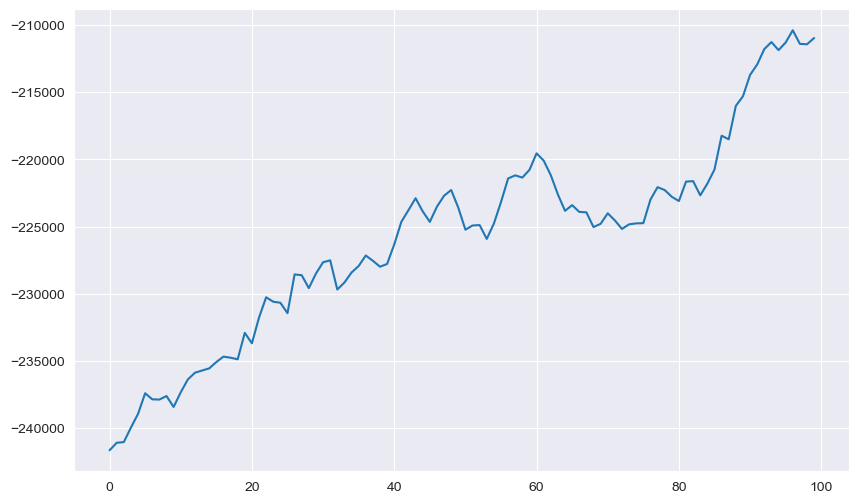

In [33]:
# run an episode of 100 steps
risk = []
for i in range(100):
    bankmodel.step()
    zerocurve.step()
    risk.append(bankmodel.calculate_risk(zerocurve,200,'Parallel'))    
sns.lineplot(risk)

In [ ]:
bankmodel.reset()
zerocurve.reset()